# **Tutorial** : create your own base map from A to Z with CartAGen, from IGN's BD TOPO
![Alt text](https://assets-global.website-files.com/63483ad423421bd16e7a7ae7/63a16770a97b930a84c77f00_voyager-positron.png)

_Source : https://carto.com/blog/new-voyager-basemap_ 
- 🙋 **For whom ?** : 
    - cartographers wishing to obtain a **customized background map** to enhance their cartographic projects, with an **open source** solution
    - **national mapping institutes** and other organizations wishing to discover the **cartographic generalization possibilities** offered by the CartAGen tool
    - anyone who wants to understand how **topographic maps** are made!


- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  


- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)

    
- 🔗 **Useful links** : 
    - [Github repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)
    - [IGN's BD TOPO](https://geoservices.ign.fr/bdtopo)

_by Paul Bourcier, 2024 - CC-BY-SA 4.0_

## ⚙️ **Part 0 :** Preparing the working environment

In [ ]:
# Importing libraries

from matplotlib import pyplot as plt # for ploting results, especially maps
import cartagen4py as c4 # the main library, containing cartographic generalization algorithms
import geopandas as gp # used to import and manipulate geographic data
import ipywidgets # creation of interactive plots
import os # navigation within the environnement
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
#from matplotlib.path import Path  # Plot generation
#from matplotlib.patches import PathPatch # Plot generation
from matplotlib.figure import Figure # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
from screeninfo import get_monitors # getting screen size
from shapely.geometry import Point, Polygon, LineString, MultiPolygon # Create and manipulate geometries
from shapely.wkt import loads # Create and manipulate geometries
from tqdm.notebook import tqdm # Creating loading bar
from time import sleep # Creating loading bar
import numpy as np # Using mathematical operations in Python

from matplotlib.path import Path
from matplotlib.patches import PathPatch

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 

## 🗺 **Part 1 :** What is cartographic generalisation and why do we need it ?

### **a/** Building a basemap from IGN's BD TOPO
BD TOPO is an IGN product consisting of a **vector database** representing all the features and infrastructures of the French (buildings, roads, administrative boundaries, etc.), with **metric precision**. 
It is therefore a good basis for the creation of a base map. 

Let's start by importing part of this database and customizing its **symbolization**. 

In [ ]:
# Importing the data of the extract (1 file per type of feature)

files = os.listdir('data/data_fd_carte_1')
layer_names = ['gdf_trainline','gdf_vegetation','gdf_graveyard','gdf_water1','gdf_transport_eqpmt','gdf_water2','gdf_road','gdf_building']
layer_list = []

for file in tqdm(files, desc = "loading data : "):
    data = gp.read_file(f'data/data_fd_carte_1/{file}')
    layer_list.append(data)

datas = {name: gdf for name, gdf in zip(layer_names, layer_list)}

if len(layer_list) == len(os.listdir('data/data_fd_carte_1')):
    print("✅ successful import")
else:
    print("❌ import failed")

loading data :   0%|          | 0/8 [00:00<?, ?it/s]

✅ successful import


displaying data layers :   0%|          | 0/8 [00:00<?, ?it/s]

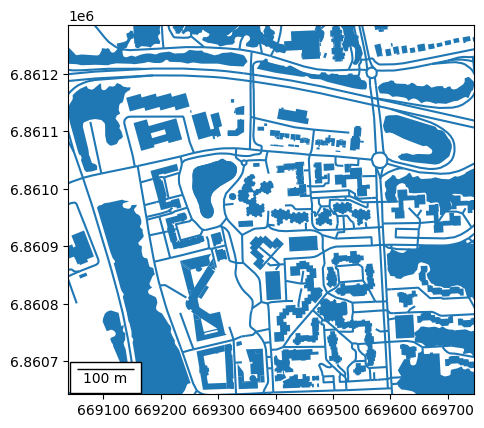

In [ ]:
# Plotting the datas without setting up symbolization

ax = datas['gdf_trainline'].plot()
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	

scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)

for name, gdf in tqdm(datas.items(), desc = "displaying data layers : "):
    gdf.plot(ax = ax)

In [ ]:
# Interactively setting up symbolization for roads

roads_sorted = [] # Creation of a list containing a gdf by degree of road importance 
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i))]) 

grid = ipywidgets.GridspecLayout(5, 5)
grid[0,0] = ipywidgets.ColorPicker(concise=False,description='col_2',value='#ffffff')
grid[1,0] = ipywidgets.ColorPicker(concise=False,description='col_3',value='#ffffff')
grid[2,0] = ipywidgets.ColorPicker(concise=False,description='col_4',value='#ffffff')
grid[3,0] = ipywidgets.ColorPicker(concise=False,description='col_5',value='#ffffff')
grid[4,0] = ipywidgets.ColorPicker(concise=False,description='col_6',value='#ffffff')
grid[0,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_2', continuous_update=False)
grid[1,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_3', continuous_update=False)
grid[2,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_4', continuous_update=False)
grid[3,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_5', continuous_update=False)
grid[4,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_6', continuous_update=False)


def plt_roads(col_2, col_3, col_4, col_5, col_6, width_2, width_3, width_4, width_5, width_6): # Function that plot each road and prepare arguments for interaction
    ax = datas['gdf_road'].plot(alpha = 0,figsize=(8,8))
    plt.xlim(669039, 669745)
    plt.ylim(6860642, 6861286)
    scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.axes.get_yaxis().set_visible(False)

    list_col = [col_2, col_3, col_4, col_5, col_6]
    list_width = [width_2, width_3, width_4, width_5, width_6]

    for i in tqdm(reversed(range(2,len(datas['gdf_road'].importance.unique())+2)), desc = "changing symbology : ", ncols = 500,total = 5):
        roads_sorted[i-2].plot(ax = ax, color = "black", linewidth = list_width[i-2]+1,alpha = 0.5) 
        roads_sorted[i-2].plot(ax = ax, color = list_col[i-2], linewidth = list_width[i-2]) 

out_road_symbo = ipywidgets.interactive_output(plt_roads, {'col_2':grid[0,0], 'col_3':grid[1,0], 'col_4':grid[2,0], 'col_5':grid[3,0], 
'col_6':grid[4,0], 'width_2':grid[0,1], 'width_3':grid[1,1], 'width_4':grid[2,1], 'width_5':grid[3,1], 'width_6':grid[4,1]})# Calls up the function for interactively defining road width and color 

display(grid,out_road_symbo)

GridspecLayout(children=(ColorPicker(value='#ffffff', description='col_2', layout=Layout(grid_area='widget001'…

Output()

💬 Since there's **a lot** of symbolization functionality to configure, let's **fast-forward** and see what our **example basemap** might look like :

displaying data layers :   0%|          | 0/5 [00:00<?, ?it/s]

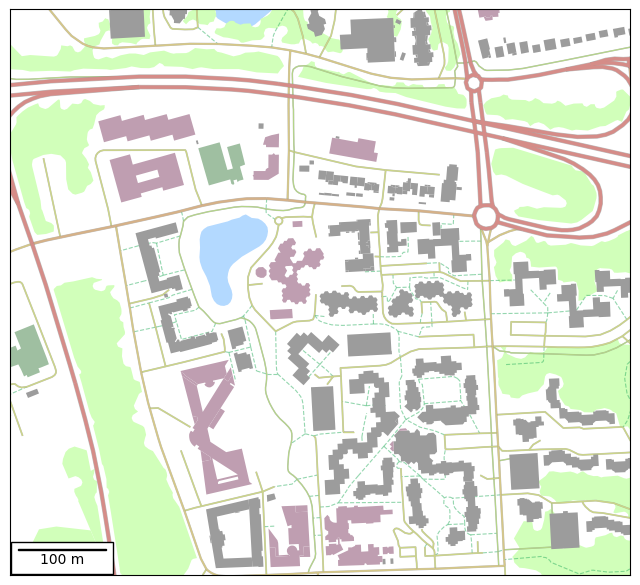

In [ ]:
# Dividing roads according to their type and importance
roads_sorted = []
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i)) & (datas['gdf_road'].nature != "Chemin") 
                                                                    & (datas['gdf_road'].nature != "Sentier") 
                                                                    & (datas['gdf_road'].nature != "Route empierrée")]) 

gdf_paths = datas['gdf_road'][(datas['gdf_road'].nature == "Chemin") | (datas['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#d58c88','#d5b188','#d5c788','#ccd588','#b4d588','#95d588']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#9c9c9c','#9c9c9c','#bf9eb1','#9c9c9c','#fff3b0','#9c9c9c','#9c9c9c','#9fbfa1'])

# Setting up the map
ax = datas['gdf_road'].plot(alpha = 0, figsize=(8,8))
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	
scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
pbar = tqdm(range(5), total = 5, desc = "displaying data layers : ")
for i in range(1):
        datas['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1.0)
        gdf_paths.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5)
        sleep(0.1)
        pbar.update(1.0)
        for i in reversed(range(2,len(datas['gdf_road'].importance.unique())+2)): 
                roads_sorted[i-2].plot(ax = ax, color = "grey", linewidth = 6.5/i ,alpha = 0.5) 
                roads_sorted[i-2].plot(ax = ax, color = list_col_roads[i-2], linewidth = 5/i)
        sleep(0.1)
        pbar.update(1.0)
        datas['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        sleep(0.1)
        pbar.update(1.0)
        datas['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0)
        sleep(0.1)
        pbar.update(1.0)
pbar.close()

💬 As you can see, by configuring the **symbolization** of our map's elements, we obtain a satisfactory basemap. 

However, the **legibility** of the map tends to **diminish** as the scale decreases (and the number of elements displayed increases)...

**Note :** This basemap could be improved by adding effects to the elements, such as **shading**. 
It should be noted that GIS environment offers more **user-friendly** tools for carrying out symbolization processes. 

### **b/** The issue of scale 
BD TOPO contains **many** different elements. As the scale (i.e. the mathematical relationship between the size of features on the map and reality) **decreases**, the number of features displayed **increases**. Sometimes there's too much information on the map. Here's an example :  

![Alt text](https://raw.githubusercontent.com/gowestmen/images/main/bd_topo_seine_et_marne.png)

Here we've displayed the BD TOPO at a **regional scale** without configuring the symbology. The result is **not readable**. The processes of transforming a map to make it readable are called **map generalization**. They can be carried out in different ways:
- by **selecting** the elements to be displayed
- parameterizing **symbology** (reducing road widths, for example)
- by performing **transformations on the entities** themselves -> that is what CartAGen is made for ! 

Let's make the same basemap on a **smaller scale**, to see to what extent entity selection and symbology settings are sometimes **not enough** to get a good result.

In [ ]:
# Importing the data of the second extract 

files = os.listdir('data/data_fd_carte_2')
layer_names_2 = ['gdf_trainline','gdf_commune','gdf_forest','gdf_graveyard','gdf_road','gdf_vegetation','gdf_sportfield','gdf_water1','gdf_water2','gdf_building']

layer_list_2 = []
for file in tqdm(files,desc = "charging second data extract"):
    data = gp.read_file(f'data/data_fd_carte_2/{file}')
    layer_list_2.append(data)

datas_2 = {name: gdf for name, gdf in zip(layer_names_2, layer_list_2)}

if len(layer_list_2) == len(os.listdir('data/data_fd_carte_2')):
    print("✅ successful import")
else:
    print("❌ import failed")

charging second data extract:   0%|          | 0/10 [00:00<?, ?it/s]

✅ successful import


displaying data layers :   0%|          | 0/11 [00:00<?, ?it/s]

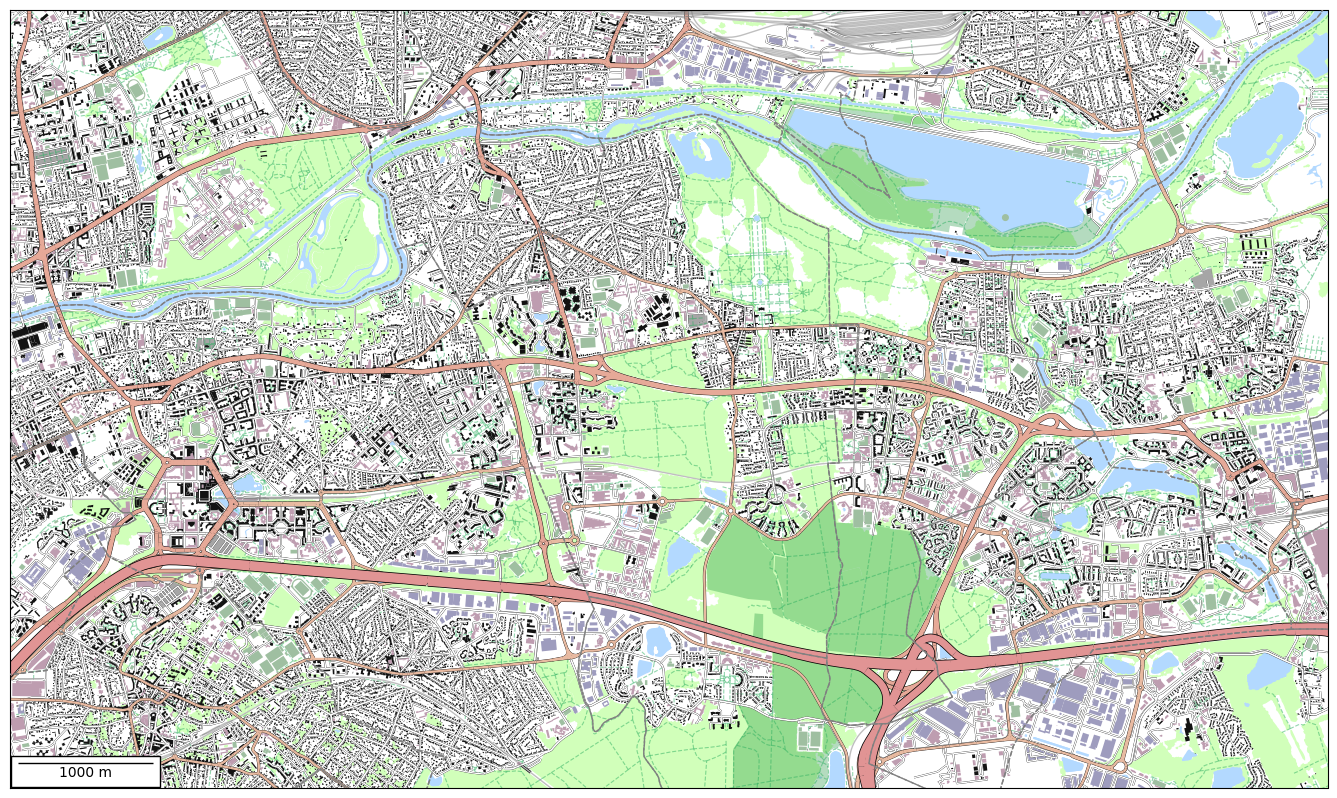

In [ ]:
# Dividing roads according to their type and importance
gdf_roads_2 = []
for i in range(1,len(datas_2['gdf_road'].importance.unique())+2):
    gdf_roads_2.append(datas_2['gdf_road'][(datas_2['gdf_road'].importance == str(i)) & (datas_2['gdf_road'].nature != "Chemin") 
                                                                    & (datas_2['gdf_road'].nature != "Sentier") 
                                                                    & (datas_2['gdf_road'].nature != "Route empierrée")])      
gdf_paths_2 = datas_2['gdf_road'][(datas_2['gdf_road'].nature == "Chemin") | (datas_2['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas_2['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#e19494','#e6a998','#e8baa1','#ffffff','#ffffff','#ffffff']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#111111','#111111','#bf9eb1','#111111','#9f9dbf','#111111','#111111','#9fbfa1'])

# Setting up the map
ax = datas_2['gdf_road'].plot(alpha = 0, figsize = (17,17))
plt.xlim(665361, 675157)
plt.ylim(6858025, 6863813)	
scalebar = AnchoredSizeBar(ax.transData,
                           1000,  
                           '1000 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
pbar = tqdm(range(11), total = 11, desc = "displaying data layers : ")
for i in range(1):
        datas_2['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_water2'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        gdf_paths_2.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        sleep(0.1)
        pbar.update(1)
        for i in reversed(range(1,len(datas_2['gdf_road'].importance.unique())+1)): 
                gdf_roads_2[i-1].plot(ax = ax, color = "black", linewidth = 6.2/i) 
                gdf_roads_2[i-1].plot(ax = ax, color = list_col_roads[i-1], linewidth = 5.1/i)
        sleep(0.1)
        pbar.update(1)       
        datas_2['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_forest'].plot(ax = ax, color = "#098a2e", zorder = 0, alpha = 0.3) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_commune'].plot(ax = ax, facecolor = "None", edgecolor = "grey", linestyle='dashed', zorder = 3) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_trainline'].plot(ax = ax, color = "grey", linewidth = 1, alpha = 0.5) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_sportfield'].plot(ax = ax, color = "#9fbfa1") 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_graveyard'].plot(ax = ax, color = "grey", alpha = 0.7) 
        sleep(0.1)
        pbar.update(1)
pbar.close()

💬 This map shows elements of the BD TOPO at **1:25000** scale. Compared with our first basemap, there are **much** more elements displayed. In addition, the map's legibility is **altered**, especially with regard to the following aspects : 
- many buildings (especially houses) are **too small** and produce **noise** in map legibility
- some roads, especially paths, are **too complex in shape**, so that they look more like a mass than a line
- some roads **intersect** with buildings, which should not happen to maintain a certain realism.

To solve these **problems**, it's not enough to modify the **symbology** or to **select** the elements to be represented. Let's take the example of paths :
- we can't really improve legibility by changing the symbology, since the **path width** is already quite small
- not displaying paths at all seems like a bad solution (depending on cartographer's needs), as they provide **useful landmarks** on the map, especially in forests.

➡️ To enhance our base map, we need to perform **transformations** on the features. Let's use CartAGen to build a cartographic generalization **workflows** !



## 🏗 **Part 2 :** Cartographic generalisation workflow for basemap creation

💬 As mentioned above, the **needs** for cartographic generalization depend on the **scale** of the intended rendering (and therefore the number of elements displayed).  
But these needs also depend on the map's **objectives**. For example, if cartographers want to display a lot of **thematic datas** on their basemap, it's in their interest to use one with a **minimalist** appearance, to stylize their map without detracting from the legibility of the thematic datas.

In other words, there isn't just one "good" generalization workflow for a given result, but several, depending on the **needs and subjectivity** of the cartographers.

Thus, this section will present different **workflows** for cartographic generalization, leading to **more or less** generalized results. 

As some map generalization algorithms can be **quite long** to run (especially on buildings), we will present our results on a **small area** in this Notebook, in order to keep loading time acceptable.

### **a/** Selection and symbolization
💬 Let's start by **selecting** the elements we want to display and setting up the desired **symbology** - the **first steps** in a cartographic generalization process.

Depending on the **level of generalization** you wish to achieve, your choices in terms of selection and symbolization will **change** :
- highly generalized : keep only the **main elements** and set a **wide** width for linear elements
- slightly generalized : retain **most elements** and set a **narrow** width for linear elements

In [ ]:
# Import and prepare third data extract
files = os.listdir('data/data_fd_carte_3')
layer_names_3 = ['gdf_trainline','gdf_water','gdf_commune','gdf_building','gdf_road','gdf_vegetation','gdf_sportfield']

def remove_z(geom): # function that delete Z coordinate
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            return Polygon([(x, y) for x, y, z in geom.exterior.coords])
        if geom.geom_type == 'LineString':
            return LineString([xy[:2] for xy in geom.coords])
    else:
        return geom

def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

layer_list_3 = []
for file in tqdm(files,desc = "charging third data extract : "): # Loading data files
    data = gp.read_file(f'data/data_fd_carte_3/{file}')
    layer_list_3.append(data)

datas_3 = {name: gdf for name, gdf in zip(layer_names_3, layer_list_3)} # Storing datas in a dictionary

for gdf in datas_3: # Only keep useful columns and perform geometry transformations
    if 'usage_1' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","usage_1","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(remove_z)
    elif 'nature' in datas_3[gdf].columns and 'importance' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","nature","importance","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(remove_z)
    else:
        if datas_3[gdf].geometry[0].geom_type != 'LineString' :
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(remove_z)
        else:
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(remove_z)

if len(layer_list_3) == len(os.listdir('data/data_fd_carte_3')): # Print success/failure message
    print("✅ successful import")
else:
    print("❌ import failed")

charging third data extract :   0%|          | 0/7 [00:00<?, ?it/s]

✅ successful import


In [ ]:
# Retrieving screen parameters to have a fixed figure size (so that cartographic scale remain the same for every screen)
list_monitor = []
for m in get_monitors():
    list_monitor.append(m)

conv = 1/100*(list_monitor[0].width/((list_monitor[0].width_mm/10)/2.54))

print(f"main screen pixel definition : {list_monitor[0].width} * {list_monitor[0].height} \nmain screen size : {list_monitor[0].width_mm/10} * {list_monitor[0].height_mm/10} cm" )

SCREEN = {
    '1:25000':(2.45*conv,2.45*conv), 
    '1:10000':(6.2*conv,6.2*conv),
    '1:7500':(8.15*conv,8.15*conv),
    '1:5000':(15.26*conv,15.26*conv)}

main screen pixel definition : 1920 * 1080 
main screen size : 53.0 * 30.0 cm


In [ ]:
# def plt_test(lw):

#     fig = plt.figure(figsize=(12, 12*(15/22.5)))
#     fig.set_layout_engine(layout='tight')

#     sub1 = fig.add_subplot(331)

#     for i in range(len(geom)):
#         path1 = Path(np.asarray(geom[i].coords)[:, :2])
#         sub1.add_patch(PathPatch(path1, facecolor="none", edgecolor='gray', linewidth=lw))
#         sub1.set_xlim(668198, 669411)
#         sub1.set_ylim(6860147, 6860869)
        
#     scalebar = AnchoredSizeBar(fig.transData,
#                             250,  
#                             '250 m',  
#                             'lower left',  
#                             pad=0.5,
#                             color='black',
#                             frameon=True,
#                             size_vertical=1)
#     sub1.add_artist(scalebar)


#     plt.show()
#     plt.close(fig)

# ipywidgets.interact(plt_test,lw = (0,5,1))

In [ ]:
# Select elements to display
grid = ipywidgets.GridspecLayout(7, 8) # Creating grid layout for our button

ROAD_TYPE = {
    '0':'one_side_road',
    '1':'two_side_road',
    '2':'roundabout',
    '3':'trail',
    '4':'rocky_road'}
ROAD_TYPE_FR = {
    '0':'Route à 1 chaussée',
    '1':'Route à 2 chaussées',
    '2':'Rond-point',
    '3':'Sentier',
    '4':'Route empierrée'}
BUILDING_TYPE = {
    '0':'residential',
    '1':'annex',
    '2':'commercial and services',
    '3':'religious',
    '4':'agricultural',
    '5':'sport facility',
    '6':'other'}
BUILDING_TYPE_FR = {
    '0':'Résidentiel',
    '1':'Annexe',
    '2':'Commercial et services',
    '3':'Religieux',
    '4':'Agricole',
    '5':'Sportif',
    '6':'Indifférencié'}

for i in range(5): # buttons for road selection according to importance level and type
    grid[i,0] = ipywidgets.Checkbox(value=True, description=f"road_importance_{i+2}")
    grid[i,1] = ipywidgets.Checkbox(value=True, description=ROAD_TYPE[f"{i}"])  
for i in range(7): # buttons for building selection according to type
    grid[i,2] = ipywidgets.Checkbox(value=True, description=BUILDING_TYPE[f"{i}"])
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='communes_boundaries')
    grid[0,4] = ipywidgets.Checkbox(value=True, description='sports_field')
    grid[0,5] = ipywidgets.Checkbox(value=True, description='trainline')
    grid[0,6] = ipywidgets.Checkbox(value=True, description='vegetation_zone')
    grid[0,7] = ipywidgets.Checkbox(value=True, description='water')
    grid[3,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

selected_data = 0 # Declaring the variable that will store the selected datas

def plt_and_select(road_importance_2,road_importance_3,road_importance_4,road_importance_5,road_importance_6,
                   one_side_road, two_side_road, roundabout, trail, rocky_road, 
                   residential, annex, commercial_services, religious, agricultural, sport_facility, other,
                   communes_boundaries,
                   sports_field,
                   trainline,
                   vegetation_zone,
                   water,scale):
    # Setting up the map
    global SCREEN
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global selected_data
    selected_data = datas_3.copy()
    
    for i in range(1): # Filtering storage variable on interactively selected features
        if road_importance_2 != True:          
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "2")]
        
        if road_importance_3 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "3")]

        if road_importance_4 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "4")]

        if road_importance_5 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "5")]

        if road_importance_6 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "6")]

        if one_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 1 chaussée")]

        if two_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 2 chaussées")]

        if roundabout != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Rond-point")]

        if trail != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Sentier")]

        if rocky_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route empierrée")]
        
        if residential != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Résidentiel")]

        if annex != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Annexe")]

        if commercial_services != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Commercial et services")]

        if religious != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Religieux")]

        if agricultural != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Agricole")]

        if sport_facility != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Sportif")]

        if other != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Indifférencié")]

        if communes_boundaries != False:
            selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = "grey")
        else:
            selected_data['gdf_commune'] = selected_data['gdf_commune'].iloc[0:0]

        if sports_field != False:
            selected_data['gdf_sportfield'].plot(ax= ax, facecolor = "red")
        else:
            selected_data['gdf_sportfield'] = selected_data['gdf_sportfield'].iloc[0:0]

        if trainline != False:
            selected_data['gdf_trainline'].plot(ax= ax, color = "black")
        else:
            selected_data['gdf_trainline'] = selected_data['gdf_trainline'].iloc[0:0]
        
        if vegetation_zone != False:
            selected_data['gdf_vegetation'].plot(ax= ax, facecolor = "green")
        else:
            selected_data['gdf_vegetation'] = selected_data['gdf_vegetation'].iloc[0:0]

        if water != False:
            selected_data['gdf_water'].plot(ax= ax, facecolor = "blue")
        else:
            selected_data['gdf_water'] = selected_data['gdf_water'].iloc[0:0]

    pbar = tqdm(range(17), total = 17, desc = "displaying data layers : ")
    for i in range(5): # Displaying roads
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i+2}")].plot(ax = ax, color = "orange", linewidth = 4*(1/(i+1)))
        pbar.update(1.0)
        selected_data['gdf_road'][(selected_data['gdf_road'].nature == ROAD_TYPE_FR[f"{i}"])].plot(ax = ax, color = "orange", linewidth = 0.5)
        pbar.update(1.0)   
    for i in range(7): # Displaying buildings
        selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == BUILDING_TYPE_FR[f"{i}"])].plot(ax = ax, color = list(np.random.choice(range(256), size=3)/256))
        pbar.update(1.0)
    pbar.close()

out = ipywidgets.interactive_output(plt_and_select, {'road_importance_2':grid[0,0],'road_importance_3':grid[1,0], 'road_importance_4':grid[2,0], 'road_importance_5':grid[3,0], 'road_importance_6':grid[4,0],
                                                     'one_side_road':grid[0,1],'two_side_road':grid[1,1], 'roundabout':grid[2,1], 'trail':grid[3,1], 'rocky_road':grid[4,1],
                                                     'residential':grid[0,2],'annex':grid[1,2],'commercial_services':grid[2,2],'religious':grid[3,2],'agricultural':grid[4,2],'sport_facility':grid[5,2],'other':grid[6,2],
                                                     'communes_boundaries':grid[0,3],
                                                     'sports_field':grid[0,4],
                                                     'trainline':grid[0,5],
                                                     'vegetation_zone':grid[0,6],
                                                     'water':grid[0,7],
                                                     'scale':grid[3,3]})   
display(grid, out)

GridspecLayout(children=(Checkbox(value=True, description='road_importance_2', layout=Layout(grid_area='widget…

Output()

In [ ]:
# set up symbology
gdf_bckgrnd = gp.GeoDataFrame(geometry=gp.GeoSeries([loads('Polygon ((668199 6860870, 669412 6860870, 669412 6860148, 668199 6860148, 668199 6860870))')]))

grid = ipywidgets.GridspecLayout(7, 9) # Creating grid layout for our button

for i in range(5): # Creating the buttons road color and width
    grid[i,0] = ipywidgets.ColorPicker(concise=False,description=f"col_road_{i+2}",value='#111111')
    grid[i,1] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description=f'width_road_{i+2}', continuous_update=False)
for i in range(7): # Creating the buildings color
    grid[i,2] = ipywidgets.ColorPicker(concise=False,description='col_'+BUILDING_TYPE[f'{i}'],value='#111111')
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='background_on_off')
    grid[1,3] = ipywidgets.ColorPicker(concise=False, description='col_bckgrnd', value='#ffffff')
    grid[4,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

    grid[0,4] = ipywidgets.ColorPicker(concise=False, description='col_sports_field', value='#111111')

    grid[0,5] = ipywidgets.ColorPicker(concise=False, description='col_communes', value='#111111')
    grid[1,5] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width_communes', continuous_update=False)

    grid[0,6] = ipywidgets.ColorPicker(concise=False, description='col_trainline', value='#111111')
    grid[1,6] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width_trainline', continuous_update=False)

    grid[0,7] = ipywidgets.ColorPicker(concise=False, description='col_vegetation', value='#111111')

    grid[0,8] = ipywidgets.ColorPicker(concise=False, description='col_water', value='#111111')

for i in range(1): # Declare variables that will store chosen values
    SYMBO_PARAM = {
        'road_col_2':'0',
        'road_col_3':'0',
        'road_col_4':'0',
        'road_col_5':'0',
        'road_col_6':'0',
        'road_width_2':'0',
        'road_width_3':'0',
        'road_width_4':'0',
        'road_width_5':'0',
        'road_width_6':'0',  
        'residential_col' :'0',
        'annex_col' :'0',
        'com_serv_col' :'0',
        'religious_col' :'0',
        'agricultural_col' :'0',
        'sport_facility_col' :'0',
        'other_col' :'0',
        'bckgrnd_col' :'0',
        'sports_field_col' :'0',
        'communes_col' :'0',
        'communes_width' :'0',
        'trainline_col' :'0',
        'trainline_width' :'0',
        'vegetation_col' :'0',
        'water_col' :'0'}

def pick_symbo(col_road_2, col_road_3, col_road_4, col_road_5, col_road_6, # Function for interactively set up symbology
               width_road_2, width_road_3, width_road_4, width_road_5, width_road_6, 
               col_residential, col_annex, col_com_serv, col_religious, col_agricultural, col_sport_facility, col_other, 
               background_on_off, col_bckgrnd,
               col_sports_field,
               col_communes, width_communes,
               col_trainline, width_trainline,
               col_vegetation,
               col_water,
               scale):

    # Setting up the map
    global SCREEN          
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global SYMBO_PARAM # Calling the dictionnary that will store parameters

    pbar = tqdm(range(18), total = 18, desc = "changing symbology : ")
    for i in range(1):
        if grid[0,3].value == True:
            gdf_bckgrnd.plot(ax= ax, color = col_bckgrnd)
            SYMBO_PARAM['bckgrnd_col'] = grid[1,3].value
            grid[1,3].description = "col_bckgrnd"
        else:
            grid[1,3].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_vegetation'].empty:
            selected_data['gdf_vegetation'].plot(ax= ax, color = col_vegetation)
            SYMBO_PARAM['vegetation_col'] = grid[0,7].value
        else:
            grid[0,7].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = "#1f2232", linewidth = width_road_6+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = col_road_6, linewidth = width_road_6)
            SYMBO_PARAM['road_col_6'] = grid[4,0].value
            SYMBO_PARAM['road_width_6'] = grid[4,1].value
        else:
            grid[4,0].description = "not selected"
            grid[4,1].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = "#1f2232", linewidth = width_road_5+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = col_road_5, linewidth = width_road_5)
            SYMBO_PARAM['road_col_5'] = grid[3,0].value
            SYMBO_PARAM['road_width_5'] = grid[3,1].value
        else:
            grid[3,0].description = "not selected"
            grid[3,1].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = "#1f2232", linewidth = width_road_4+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = col_road_4, linewidth = width_road_4)
            SYMBO_PARAM['road_col_4'] = grid[2,0].value
            SYMBO_PARAM['road_width_4'] = grid[2,1].value
        else:
            grid[2,0].description = "not selected"
            grid[2,1].description = "not selected"
        pbar.update(1.0)   

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = "#1f2232", linewidth = width_road_3+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = col_road_3, linewidth = width_road_3)
            SYMBO_PARAM['road_col_3'] = grid[1,0].value
            SYMBO_PARAM['road_width_3'] = grid[1,1].value
        else:
            grid[1,0].description = "not selected"
            grid[1,1].description = "not selected"
        pbar.update(1.0)     

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = "#1f2232", linewidth = width_road_2+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = col_road_2, linewidth = width_road_2)
            SYMBO_PARAM['road_col_2'] = grid[0,0].value
            SYMBO_PARAM['road_width_2'] = grid[0,1].value
        else:
            grid[0,0].description = "not selected"
            grid[0,1].description = "not selected"
        pbar.update(1.0)   

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].plot(ax= ax, color = col_residential)
            SYMBO_PARAM['residential_col'] = grid[0,2].value
        else:
            grid[0,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].plot(ax= ax, color = col_annex)
            SYMBO_PARAM['annex_col'] = grid[1,2].value
        else:
            grid[1,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].plot(ax= ax, color = col_com_serv)
            SYMBO_PARAM['com_serv_col'] = grid[2,2].value
        else:
            grid[2,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].plot(ax= ax, color = col_religious)
            SYMBO_PARAM['religious_col'] = grid[3,2].value
        else:
            grid[3,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].plot(ax= ax, color = col_agricultural)
            SYMBO_PARAM['agricultural_col'] = grid[4,2].value
        else:
            grid[4,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].plot(ax= ax, color = col_sport_facility)
            SYMBO_PARAM['sport_facility_col'] = grid[5,2].value
        else:
            grid[5,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].plot(ax= ax, color = col_other)
            SYMBO_PARAM['other_col'] = grid[6,2].value
        else:
            grid[6,2].description = "not selected"
        pbar.update(1.0)      

        if not selected_data['gdf_sportfield'].empty:
            selected_data['gdf_sportfield'].plot(ax= ax, color = col_sports_field)
            SYMBO_PARAM['sports_field_col'] = grid[0,4].value
        else:
            grid[0,4].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_commune'].empty:
            selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = col_communes, linewidth = width_communes,linestyle='dashed')
            SYMBO_PARAM['communes_col'] = grid[0,5].value
            SYMBO_PARAM['communes_width'] = grid[1,5].value
        else:
            grid[0,5].description = "not selected"
            grid[1,5].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_trainline'].empty:
            selected_data['gdf_trainline'].plot(ax= ax, color = col_trainline, linewidth = width_trainline)
            SYMBO_PARAM['trainline_col'] = grid[0,6].value
            SYMBO_PARAM['trainline_width'] = grid[1,6].value
        else:
            grid[0,6].description = "not selected"
            grid[1,6].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_water'].empty:
            selected_data['gdf_water'].plot(ax= ax, color = col_water)
            SYMBO_PARAM['water_col'] = grid[0,8].value
        else:
            grid[0,8].description = "not selected"
        pbar.update(1.0) 
    pbar.close()

out_2 = ipywidgets.interactive_output(pick_symbo,{'col_road_2':grid[0,0],'col_road_3':grid[1,0],'col_road_4':grid[2,0],'col_road_5':grid[3,0], 'col_road_6':grid[4,0],
                                                  'width_road_2':grid[0,1],'width_road_3':grid[1,1],'width_road_4':grid[2,1],'width_road_5':grid[3,1],'width_road_6':grid[4,1],
                                                  'col_residential':grid[0,2], 'col_annex':grid[1,2], 'col_com_serv':grid[2,2], 'col_religious':grid[3,2], 'col_agricultural':grid[4,2], 'col_sport_facility':grid[5,2], 'col_other':grid[6,2],
                                                  'background_on_off':grid[0,3], 'col_bckgrnd':grid[1,3],
                                                  'col_sports_field':grid[0,4],
                                                  'col_communes':grid[0,5], 'width_communes':grid[1,5],
                                                  'col_trainline':grid[0,6], 'width_trainline':grid[1,6],
                                                  'col_vegetation':grid[0,7],
                                                  'col_water':grid[0,8],
                                                  'scale':grid[4,3]})

display(grid, out_2)


GridspecLayout(children=(ColorPicker(value='#111111', description='col_road_2', layout=Layout(grid_area='widge…

Output()

💬 Now that we have done the **selection and symbolization**, it's time to dive into the **transformation** of our elements to complete our generalization processes.

The following sections will present proposed workflows for three **levels of generalization**. If the code cell relates to the targeted generalization level (indicated by the 🟡, 🟠 or 🔴 icon), click **"proceed"** after running it (otherwise, run it and click **"skip"**).

- 🟡 **Slightly generalized :** most map details are preserved -> useful for large-scale maps (neighborhood) 
- 🟠 **Medium generalization :** intermediate between very generalized and lightly generalized rendering.
- 🔴 **Very generalized :** only the main map structures are preserved -> useful for small scales or minimalist basemaps


### **a/** Road generalization

Let's start by generalizing roads and paths so they have less details

In [ ]:
# 🟡🟠🔴
# Step 1 : Using the "detect_dead_ends" algorithm on roads and paths, to select the part of their geometry that we want to remove

skip = ipywidgets.ToggleButton(value=False, description='skip', button_style='', icon='check')
proceed = ipywidgets.ToggleButton(value=False, description='proceed', button_style='', icon='check')
container = ipywidgets.TwoByTwoLayout(top_left=skip, top_right=proceed)

dead_ends = 0
out_dtc_de = 0

def skip_step(change):
    global dead_ends
    global out_dtc_de
    if skip.value:
        print("process skiped")
        dead_ends = gp.GeoDataFrame(geometry=gp.GeoSeries([]))     
    elif proceed.value:
        def plt_dtc_de(outside_faces, scale = '1:7500'):
            global dead_ends
            for i in tqdm(range(1)):
                #Preparing the variable containing dead_ends (/!\ processing need to be performed on all the road network)
                dead_ends = c4.detect_dead_ends(selected_data['gdf_road'], outside_faces = outside_faces)
    
                # Setting up the map
                global SCREEN
                fig = plt.figure(figsize=SCREEN[scale])
                ax = fig.add_subplot(111)
                plt.xlim(668198, 669411)
                plt.ylim(6860147, 6860869)		
                scalebar = AnchoredSizeBar(ax.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
                ax.add_artist(scalebar)

                # Display the result
                selected_data['gdf_road'].plot(ax =ax, linewidth = 1)
                dead_ends.plot(ax = ax, color = "red", linewidth = 1) 

        out_dtc_de = ipywidgets.interactive(plt_dtc_de, outside_faces = True, scale = ['1:25000','1:10000', '1:7500', '1:5000'])
        display(out_dtc_de)
        
skip.observe(skip_step, 'value')
proceed.observe(skip_step, 'value')
display(container)

TwoByTwoLayout(children=(ToggleButton(value=False, description='skip', icon='check', layout=Layout(grid_area='…

interactive(children=(Checkbox(value=True, description='outside_faces'), Dropdown(description='scale', index=2…

In [ ]:
# 🟡🟠🔴
# Step 2 : Removing part of the paths/roads considered as dead_ends by using "eliminate_dead_ends"
skip = ipywidgets.ToggleButton(value=False, description='skip', button_style='', icon='check')
proceed = ipywidgets.ToggleButton(value=False, description='proceed', button_style='', icon='check')
container = ipywidgets.TwoByTwoLayout(top_left=skip, top_right=proceed)

collapsed_de = 0 
out_elim_de = 0
roads_flat = 0

def skip_step(change):
    global collapsed_de
    global out_elim_de
    #global selected_data['gdf_road']
    global dead_ends
    global roads_flat
    if skip.value:
        print("process skiped")
        collapsed_de = selected_data['gdf_road'].copy()     
    elif proceed.value:
        def remove_z(geom):
            if geom.has_z:
                return LineString([xy[:2] for xy in geom.coords])
            else:
                return geom
        roads_flat = selected_data['gdf_road'].copy() 
        roads_flat['geometry'] = roads_flat['geometry'].apply(remove_z) 
        dead_ends['geometry'] = dead_ends['geometry'].apply(remove_z)

        def plt_elim_de(length, klongest, scale = "1:7500"):
            global collapsed_de
            for i in tqdm(range(1)):
                collapsed_de = c4.eliminate_dead_ends(roads_flat, dead_ends, length, klongest)

                # Setting up the map
                global SCREEN
                fig = plt.figure(figsize=SCREEN[scale])
                ax = fig.add_subplot(111)
                plt.xlim(668198, 669411)
                plt.ylim(6860147, 6860869)		
                scalebar = AnchoredSizeBar(ax.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
                ax.add_artist(scalebar)
                
                collapsed_de.plot(ax =ax, linewidth = 0.8)

        out_elim_de = ipywidgets.interactive(plt_elim_de, length = ipywidgets.FloatSlider(value = 0,min = 0,max = 500,step = 10,continuous_update=False),
                                                          klongest = True,
                                                          scale = ['1:25000','1:10000', '1:7500', '1:5000'])
        display(out_elim_de)

skip.observe(skip_step, 'value')
proceed.observe(skip_step, 'value')
display(container)


TwoByTwoLayout(children=(ToggleButton(value=False, description='skip', icon='check', layout=Layout(grid_area='…

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='length', max=500.0, step=10…

In [ ]:
SYMBO_PARAM

{'road_col_2': '#d92020',
 'road_col_3': '#de7f3f',
 'road_col_4': '#dab177',
 'road_col_5': '#ede3b6',
 'road_col_6': '#fcfde8',
 'road_width_2': 5.8,
 'road_width_3': 4.3999999999999995,
 'road_width_4': 3.4,
 'road_width_5': 2.6,
 'road_width_6': 1.0,
 'residential_col': '#382424',
 'annex_col': '#382424',
 'com_serv_col': '#e0cde9',
 'religious_col': '#ad75bd',
 'agricultural_col': '#817e6a',
 'sport_facility_col': '#a6ada4',
 'other_col': '#9c9c9c',
 'bckgrnd_col': '#edf7f7',
 'sports_field_col': '#a6ada4',
 'communes_col': '#6b6b6b',
 'communes_width': 2.4,
 'trainline_col': '#111111',
 'trainline_width': 1.0,
 'vegetation_col': '#82ba89',
 'water_col': '#86c1d5'}

In [ ]:
# 🟡🟠🔴
# Display intermediary results    
symbology_on_off = ipywidgets.Checkbox(value=True, description='symbology_on')

def bf_af_1(scale='1:7500', symbology_on= True):
    global SCREEN
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    if symbology_on == True:
        pbar = tqdm(range(34), total = 34, desc = "displaying datas : ")
        
        for i in reversed(range(2,7)):
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)

            collapsed_de[(collapsed_de.importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            collapsed_de[(collapsed_de.importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)

            selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 

            selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0)
            selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            
            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
            selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)
            selected_data['gdf_building'].plot(ax=ax2, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)

            selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)

            selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)

            selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        pbar.close()
        
    else:
        pbar = tqdm(range(2), total = 2, desc = "displaying datas : ")
        for i in range(1):
            selected_data['gdf_road'].plot(ax =ax1, linewidth = 0.8)
            pbar.update(1.0)
            collapsed_de.plot(ax =ax2, linewidth = 0.8)
            pbar.update(1.0)
        pbar.close()

        
ipywidgets.interact(bf_af_1, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = True)

interactive(children=(Dropdown(description='scale', index=2, options=('1:25000', '1:10000', '1:7500', '1:5000'…

<function __main__.bf_af_1(scale='1:7500', symbology_on=True)>

In [ ]:
# 🟡🟠🔴
# Trying detect roundabout
roundabouts = 0

def plt_rb(area_threshold, miller_index):
    for i in tqdm(range(1)):
        global roundabouts
        roundabouts = c4.detect_roundabouts(collapsed, area_threshold = area_threshold, miller_index = miller_index)

        # Setting up the map
        ax = collapsed.plot(alpha = 0, figsize = (12,12))
        plt.xlim(665361, 675157)
        plt.ylim(6858025, 6863813)	
        scalebar = AnchoredSizeBar(ax.transData,
                                1000,  
                                '1000 m',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        # Display the result
        collapsed.plot(ax =ax, linewidth = 0.8)
        roundabouts.plot(ax = ax, color = "orange") 

out_dtct_rb = ipywidgets.interactive(plt_rb, area_threshold = ipywidgets.IntSlider(value =4000, min = 0,max = 10000,step = 100,continuous_update=False),
                                             miller_index = ipywidgets.FloatSlider(value =0.95, min = 0,max = 1,step = 0.01,continuous_update=False))
display(out_dtct_rb)

interactive(children=(IntSlider(value=4000, continuous_update=False, description='area_threshold', max=10000, …

In [ ]:
# 🟡🟠🔴
# Trying detect branching crossroads
bc = 0

def plt_dtct_bc(area_threshold, maximum_distance_area, allow_middle_node, middle_angle_tolerance, allow_single_4degree_node):
    for i in tqdm(range(1)):
        global bc 
        bc = c4.detect_branching_crossroads(collapsed, area_threshold = area_threshold, maximum_distance_area = maximum_distance_area,
                                            roundabouts = roundabouts, allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)

        # Setting up the map
        ax = collapsed.plot(alpha = 0, figsize = (12,12))
        plt.xlim(665361, 675157)
        plt.ylim(6858025, 6863813)	
        scalebar = AnchoredSizeBar(ax.transData,
                                1000,  
                                '1000 m',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        # Display the result
        collapsed.plot(ax =ax, linewidth = 0.8)
        bc.plot(ax = ax, color = "orange") 

out_dtct_bc = ipywidgets.interactive(plt_dtct_bc, area_threshold = ipywidgets.IntSlider(value =4000, min = 0,max = 10000,step = 100,continuous_update=False),
                                             maximum_distance_area = ipywidgets.FloatSlider(value =0.5, min = 0,max = 1,step = 0.025,continuous_update=False), 
                                             allow_middle_node = True, middle_angle_tolerance = ipywidgets.FloatSlider(value =10, min = 0,max = 40,step = 1,continuous_update=False), 
                                             allow_single_4degree_node = True)
display(out_dtct_bc)

interactive(children=(IntSlider(value=4000, continuous_update=False, description='area_threshold', max=10000, …

In [ ]:
# Collapse BR

In [ ]:
# 🟡🟠🔴
# Trying collapse roundabout
def plt_cllpse_rb(maximum_diameter):
    for i in tqdm(range(1)):
        collapsed_2 = c4.collapse_roundabouts(collapsed, roundabouts, maximum_diameter = maximum_diameter)

        # Setting up the map
        ax = collapsed.plot(alpha = 0, figsize = (12,12))
        plt.xlim(665361, 675157)
        plt.ylim(6858025, 6863813)	
        scalebar = AnchoredSizeBar(ax.transData,
                                1000,  
                                '1000 m',  
                                'lower left',  
                                pad=0.5,
                                color='black',
                                frameon=True,
                                size_vertical=1)
        ax.add_artist(scalebar)

        # Display the result
        roundabouts.plot(ax =ax)
        collapsed_2.plot(ax = ax, color = "orange", linewidth = 0.8) 

out_cllpse_rb = ipywidgets.interactive(plt_cllpse_rb, maximum_diameter = ipywidgets.IntSlider(value =20, min = 0,max = 500,step = 5, continuous_update=False))
display(out_cllpse_rb)

interactive(children=(IntSlider(value=20, continuous_update=False, description='maximum_diameter', max=500, st…

In [ ]:
# # detect_dual_carriageways --- standby for now

# def plt_dtc_dc(concavity, elongation, compactness, area, width, huber):
#     for i in tqdm(range(1)):
#         dc = c4.detect_dual_carriageways(collapsed, concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber)
        
#         ax = collapsed.plot(alpha = 0, figsize = (17,17))
#         plt.xlim(665361, 675157)
#         plt.ylim(6858025, 6863813)	
#         scalebar = AnchoredSizeBar(ax.transData,
#                                         1000,  
#                                         '1000 m',  
#                                         'lower left',  
#                                         pad=0.5,
#                                         color='black',
#                                         frameon=True,
#                                         size_vertical=1)
#         ax.add_artist(scalebar)

#         collapsed.plot(ax= ax, color = "grey",linewidth = 0.8,alpha = 0.5)
#         dc.plot(ax=ax)

# out_dtct_dc = ipywidgets.interactive(plt_dtc_dc, concavity = ipywidgets.FloatSlider(value =0.85, min = 0,max = 1,step = 0.05,continuous_update=False), 
#                                                  elongation = ipywidgets.IntSlider(value =6.0, min = 0,max = 10,step = 1,continuous_update=False), 
#                                                  compactness = ipywidgets.FloatSlider(value =0.12, min = 0,max = 1,step = 0.05,continuous_update=False),
#                                                  area = ipywidgets.IntSlider(value = 60000, min = 0,max = 100000,step = 1000,continuous_update=False),
#                                                  width = ipywidgets.IntSlider(value = 20.0, min = 0,max = 40,step = 5,continuous_update=False),
#                                                  huber = ipywidgets.IntSlider(value = 16, min = 0,max = 32,step = 4,continuous_update=False))
# display(out_dtct_dc)

In [ ]:
# # collapse_dual_carriageways --- standby for now
# collapsed = c4.eliminate_dead_ends(roads_flat, dead_ends, length_de_glb, keep_longest = False)
# dc = c4.detect_dual_carriageways(collapsed, concavity = concavity_glb, elongation = elongation_glb,
#                                     compactness = compactness_glb, area = area_glb, width = width_glb, huber = huber_glb)
# collapsed2 = c4.collapse_dual_carriageways(collapsed,dc, sigma = None)

# ax = collapsed.plot(alpha = 0, figsize = (17,17))
# plt.xlim(665361, 675157)
# plt.ylim(6858025, 6863813)	
# scalebar = AnchoredSizeBar(ax.transData,
#                                     1000,  
#                                     '1000 m',  
#                                     'lower left',  
#                                     pad=0.5,
#                                     color='black',
#                                     frameon=True,
#                                     size_vertical=1)
# ax.add_artist(scalebar)

# collapsed2.plot(ax=ax, linewidth = 0.8)

In [ ]:
# trying to detect pastiness 
# collapsed = collapsed = c4.eliminate_dead_ends(roads_flat, dead_ends, length_de_glb, keep_longest = False)
# pasti = []

# for line in collapsed.geometry:   
#     data = c4.detect_pastiness(line,600)
#     pasti.append(data)

In [ ]:
# def plt_choose_roads_nat(one_side_road,two_side_road,roundabout,path,trail,rocky_road,highway,road_ramp):
#         global final_gdf_road

#         # Setting up the map
#         ax = datas_2['gdf_road'].plot(alpha = 0, figsize = (17,17))
#         plt.xlim(665361, 675157)
#         plt.ylim(6858025, 6863813)	
#         scalebar = AnchoredSizeBar(ax.transData,
#                            1000,  
#                            '1000 m',  
#                            'lower left',  
#                            pad=0.5,
#                            color='black',
#                            frameon=True,
#                            size_vertical=1)
#         ax.add_artist(scalebar)

#         for layer_name, gdf in tqdm(datas_2.items()):
#                 if layer_name == 'gdf_commune' or layer_name == 'gdf_road':
#                         pass
#                 else:
#                         gdf.plot(ax= ax)
        
#         if one_side_road == True:
#             final_gdf_road[(final_gdf_road.nature == "Route à 1 chaussée")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Route à 1 chaussée")]

#         if two_side_road == True:
#             final_gdf_road[(final_gdf_road.nature == "Route à 2 chaussées")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Route à 2 chaussées")]
        
#         if roundabout == True:
#             final_gdf_road[(final_gdf_road.nature == "Rond-point")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Rond-point")]

#         if path == True:
#             final_gdf_road[(final_gdf_road.nature == "Chemin")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Chemin")]

#         if trail == True:
#             final_gdf_road[(final_gdf_road.nature == "Sentier")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Sentier")]

#         if rocky_road == True:
#             final_gdf_road[(final_gdf_road.nature == "Route empierrée")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Route empierrée")]
        
#         if road_ramp == True:
#             final_gdf_road[(final_gdf_road.nature == "Bretelle")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Bretelle")]

#         if highway == True:
#             final_gdf_road[(final_gdf_road.nature == "Type autoroutier")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.nature != "Type autoroutier")]


# ipywidgets.interact(plt_choose_roads_nat, one_side_road = True,two_side_road= True,roundabout= True,path= True,trail= True,rocky_road= True,highway= True,road_ramp= True)

interactive(children=(Checkbox(value=True, description='one_side_road'), Checkbox(value=True, description='two…

<function __main__.plt_choose_roads_nat(one_side_road, two_side_road, roundabout, path, trail, rocky_road, highway, road_ramp)>

In [ ]:
# # Step 0 : Select the roads to be displayed or further generalised 

# final_gdf_road = 0

# def plt_choose_roads_imp(importance_1,importance_2,importance_3,importance_4,importance_5,importance_6):
     
#         global final_gdf_road
#         final_gdf_road = datas_2['gdf_road'].copy()

#         # Setting up the map
#         ax = datas_2['gdf_road'].plot(alpha = 0, figsize = (17,17))
#         plt.xlim(665361, 675157)
#         plt.ylim(6858025, 6863813)	
#         scalebar = AnchoredSizeBar(ax.transData,
#                            1000,  
#                            '1000 m',  
#                            'lower left',  
#                            pad=0.5,
#                            color='black',
#                            frameon=True,
#                            size_vertical=1)
#         ax.add_artist(scalebar)

#         for layer_name, gdf in tqdm(datas_2.items()):
#                 if layer_name == 'gdf_commune' or layer_name == 'gdf_road':
#                         pass
#                 else:
#                         gdf.plot(ax= ax)

#         if importance_1 == True:
#             final_gdf_road[(final_gdf_road.importance == "1")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "1")]
        
#         if importance_2 == True:
#             final_gdf_road[(final_gdf_road.importance == "2")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "2")]

#         if importance_3 == True:
#             final_gdf_road[(final_gdf_road.importance == "3")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "3")]
        
#         if importance_4 == True:
#             final_gdf_road[(final_gdf_road.importance == "4")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "4")]
        
#         if importance_5 == True:
#             final_gdf_road[(final_gdf_road.importance == "5")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "5")]

#         if importance_6 == True:
#             final_gdf_road[(final_gdf_road.importance == "6")].plot(ax = ax, color = "orange")  
#         else:
#                 final_gdf_road = final_gdf_road[(final_gdf_road.importance != "6")]

# ipywidgets.interact(plt_choose_roads_imp, importance_1 = True, importance_2 = True, importance_3 = True, importance_4 =True, importance_5 = True, importance_6 =True)


In [ ]:
# Third : using simplification algorithm

# area_glb = 0

# def plt_path_gen(final_scale=20000):

#     test_path_3 = roads_flat.copy()


#     # global area_glb
#     # area_glb = area

#     # Setting up the map
#     ax = roads_flat.plot(alpha = 0, figsize = (12,12))
#     plt.xlim(665361, 675157)
#     plt.ylim(6858025, 6863813)	
#     scalebar = AnchoredSizeBar(ax.transData,
#                            1000,  
#                            '1000 m',  
#                            'lower left',  
#                            pad=0.5,
#                            color='black',
#                            frameon=True,
#                            size_vertical=1)
#     ax.add_artist(scalebar)

#     slines = []
#     for line in test_path_3.geometry: 
#         simplified = c4.raposo_simplification(line, 2500, final_scale, centroid=True, tobler=False)
#         slines.append(simplified)
#     generalized = gp.GeoSeries(slines)
#     generalized.plot(ax =ax)

# ipywidgets.interact(plt_path_gen, final_scale = (20000,30000))

In [ ]:
# Step 3 : Using homemade simplification algorithm

# def filter_vertices(line, min_distance):
#     coords = list(line.coords)
#     filtered_coords = [coords[0]]  # Keep first vertice
    
#     for i in range(1, len(coords)):
#         if LineString([filtered_coords[-1], coords[i]]).length >= min_distance:
#             filtered_coords.append(coords[i])
    
#     return LineString(filtered_coords) if len(filtered_coords) > 1 else loads('LineString (668592.477 6861762.780, 68594.879 6861762.734)')

# dist_hm_simplification_glb = 0
# def plt_roads(dist=0):
#     collapsed = c4.eliminate_dead_ends(roads_flat, dead_ends, length_de_glb, keep_longest = False)
#     # test_path = roads_flat.copy()
#     # test_path = test_path.dropna(subset=['geometry'])
#     global dist_hm_simplification_glb 
#     dist_hm_simplification_glb = dist

#      # Setting up the map
#     ax = roads_flat.plot(alpha = 0, figsize = (12,12))
#     plt.xlim(665361, 675157)
#     plt.ylim(6858025, 6863813)	
#     scalebar = AnchoredSizeBar(ax.transData,
#                            1000,  
#                            '1000 m',  
#                            'lower left',  
#                            pad=0.5,
#                            color='black',
#                            frameon=True,
#                            size_vertical=1)
#     ax.add_artist(scalebar)

#     collapsed['geometry'] = [filter_vertices(line, dist) for line in collapsed['geometry']]
#     collapsed.plot(ax = ax)

# ipywidgets.interact(plt_roads, dist = (0,200,5))

In [ ]:
# Step 4 : removing path section under a certain length

# length_glb = 0

# def plt_path_gen(length=0):
#     # global dist_hm_simplification_glb
#     # test_path_2 = roads_flat.copy()
#     # test_path_2['geometry'] = [filter_vertices(line, dist_hm_simplification_glb) for line in test_path_2['geometry']]
#     collapsed = c4.eliminate_dead_ends(roads_flat, dead_ends, length_de_glb, keep_longest = False)
#     collapsed["length"] = collapsed.geometry.length

#     global length_glb
#     length_glb = length

#     # Setting up the map
#     ax = roads_flat.plot(alpha = 0, figsize = (12,12))
#     plt.xlim(665361, 675157)
#     plt.ylim(6858025, 6863813)	
#     scalebar = AnchoredSizeBar(ax.transData,
#                            1000,  
#                            '1000 m',  
#                            'lower left',  
#                            pad=0.5,
#                            color='black',
#                            frameon=True,
#                            size_vertical=1)
#     ax.add_artist(scalebar)

#     collapsed[(collapsed.length >= length)].plot(ax =ax)

# ipywidgets.interact(plt_path_gen, length = (0,150,10))

In [ ]:
# 🟡🟠🔴
# Display results 

In [ ]:
# 🟡🟠🔴
# Trying BuildStrokes

In [ ]:
# 🟡🟠🔴
# Display results 

### **b/** Building generalisation

In [ ]:
# Step one : calculate area per building to divide buildings into two groups
buildings = datas_2["gdf_building"].copy()
buildings["area"] = buildings.geometry.area

def multipolygon_to_polygon(geom):
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

buildings.geometry = buildings.geometry.apply(multipolygon_to_polygon)

def remove_z_dimension(geom):
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            return Polygon([(x, y) for x, y, z in geom.exterior.coords])
        else: 
            print(oops)
    return geom

buildings.geometry = buildings.geometry.apply(remove_z_dimension)

area_building_glb = 0

def plt_area_building(area):
    global area_building_glb
    area_building_glb = area

    ax = buildings.plot(alpha = 0, figsize = (17,17))
    plt.xlim(665361, 675157)
    plt.ylim(6858025, 6863813)	
    scalebar = AnchoredSizeBar(ax.transData,
                                    1000,  
                                    '1000 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)

    buildings_big = buildings[(buildings.area >= area)]
    buildings_small = buildings[(buildings.area < area)]

    buildings_big.plot(ax = ax, color = "orange")
    buildings_small.plot(ax = ax, color = "blue")

ipywidgets.interact(plt_area_building, area = (0, 1000, 10))

In [ ]:
buildings_small = buildings[(buildings.area < area_building_glb)]
list(buildings_small.geometry)

In [ ]:
buildings_small = buildings[(buildings.area < area_building_glb)]
building_small_ok = list(buildings_small.geometry)
merged_buildings = c4.morphological_amalgamation(building_small_ok, 10, 10)

In [ ]:
# Step two : merge small building with "morphological amalgamation"
buildings_small = buildings[(buildings.area < area_building_glb)]

buffer_ma_glb = 0
edge_length_glb = 0

def plt_merged_building(buffer_size = 1.0, edge_length = 1.0):
    global buffer_ma_glb
    buffer_ma_glb = buffer_size
    global edge_length_glb
    edge_length_glb = edge_length

    ax = buildings.plot(alpha = 0, figsize = (17,17))
    plt.xlim(665361, 675157)
    plt.ylim(6858025, 6863813)	
    scalebar = AnchoredSizeBar(ax.transData,
                                    1000,  
                                    '1000 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)

    merged_buildings = c4.morphological_amalgamation(list(buildings_small.geometry), buffer_size, edge_length)
    

ipywidgets.interact(plt_merged_building, buffer_size = (0, 50, 1), edge_length = (0, 40, 1))

In [ ]:
# Remove remaining small isolated buildings

In [ ]:
# Step three : simplifie big buildings

building_big = buildings[(buildings.area >= area_building_glb)]

bbig_simp = []
for geom in list(buildings_big.geometry):
    bbig_simp.append(c4.building_simplification_ruas(geom,5.0))

ax = collapsed.plot(alpha = 0, figsize = (17,17))
plt.xlim(665361, 675157)
plt.ylim(6858025, 6863813)	
scalebar = AnchoredSizeBar(ax.transData,
                                    1000,  
                                    '1000 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)   
ax.add_artist(scalebar)

bbig_simp_plt = gp.GeoSeries(bbig_simp)
bbig_simp_plt.plot(ax =ax, color = "orange")

In [ ]:
# Display results

In [ ]:
# Step four : displace buildings if needed

In [ ]:
# Display results

💬 Cartographic generalization involves many **types** of transformation. Here are the main ones : 

![Alt text](https://raw.githubusercontent.com/gowestmen/images/main/carto_generalization_operators.png)

Source: Mustière, 2001. URL: https://www.researchgate.net/figure/Some-generalization-operations-translated-and-adapted-from-Musti-re-2001_fig2_220144000_

The use of these **operators** often requires a **try and fail** approach, especially when it is necessary to **chain** several processes. This section shows a proposed **workflow** for our basemap, using the CartAGen tool. For some processes, you can **interactively** try out different parameters to see their effect. 